In [1]:
# Import libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import sys
import cv2
import re
import logging
from collections import defaultdict
import scipy
import skimage
import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
import json
from datetime import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Any, Tuple, List
import re


# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Configure Neurite backend for VoxelMorph
os.environ['NEURITE_BACKEND'] = 'tensorflow'  # Must be set BEFORE importing neurite/voxelmorph
import neurite
from data.voxelmorph import voxelmorph as vxm



# Verify installed packages
print("\n--- Package Versions ---")
print(f"- Python: {sys.version.split()[0]}")
print(f"- TensorFlow: {tf.__version__}")
print(f"- VoxelMorph: {vxm.__version__ if hasattr(vxm, '__version__') else 'custom'}")
print(f"- Neurite: {neurite.__version__}")
print(f"- OpenCV: {cv2.__version__}")
print(f"- scikit-image: {skimage.__version__}")
print(f"- Matplotlib: {matplotlib.__version__}")
print(f"- tqdm: {tqdm.__version__}")
print(f"- SciPy: {scipy.__version__}")


# Set up environment paths
print("\n--- Environment Configuration ---")
print(f"Neurite backend: {neurite.backend}")
print(f"VoxelMorph path: {os.path.dirname(vxm.__file__)}")
print(f"Python path: {sys.path[:3]}...")



# Define data directories based on environment
LOCAL_DATA_DIR = './data'  # Default data directory for local execution
print(f"Using data directory: {LOCAL_DATA_DIR}")



--- Package Versions ---
- Python: 3.10.9
- TensorFlow: 2.19.0
- VoxelMorph: 0.2
- Neurite: 0.2
- OpenCV: 4.11.0
- scikit-image: 0.25.2
- Matplotlib: 3.10.1
- tqdm: 4.67.1
- SciPy: 1.15.2

--- Environment Configuration ---
Neurite backend: tensorflow
VoxelMorph path: d:\study\graduation_project\VXM\data\voxelmorph\voxelmorph
Python path: ['c:\\Users\\AliBadran\\AppData\\Local\\Programs\\Python\\Python310\\python310.zip', 'c:\\Users\\AliBadran\\AppData\\Local\\Programs\\Python\\Python310\\DLLs', 'c:\\Users\\AliBadran\\AppData\\Local\\Programs\\Python\\Python310\\lib']...
Using data directory: ./data


In [2]:
def create_path_structure(base_path):
    """Create and return a dictionary with all necessary data paths"""
    paths = {
        # Base paths
        'BASE_DATA_PATH': base_path,
        'MODELS_BASE_PATH': os.path.join(base_path, 'Models'),
        
        # ACDC and Sunnybrook paths
        'ACDC_BASE': '',
        'SUNNYBROOK_BASE': '',
        
        # Regular data paths
        'train_data': os.path.join(base_path, 'train'),
        'val_data': os.path.join(base_path, 'val'),
        'test_data': os.path.join(base_path, 'test'),
        'mask_data': os.path.join(base_path, 'ACDC-Masks-1'),
        'MODEL_TESTING_PATH': os.path.join(base_path, 'model_testing'),
        
        # Simulated data paths
        'train_simulated_data': os.path.join(base_path, 'Simulated_train'),
        'val_simulated_data': os.path.join(base_path, 'Simulated_val'),
        'test_simulated_data': os.path.join(base_path, 'Simulated_test'),
        'mask_simulated_data': os.path.join(base_path, 'Simulated_masks'),
        'displacement_simulated_data': os.path.join(base_path, 'Simulated_displacements'),
    }
    
    # Convenience aliases
    paths['SIMULATED_DATA_PATH'] = paths['test_simulated_data']
    paths['SIMULATED_MASK_PATH'] = paths['mask_simulated_data']
    paths['SIMULATED_DISP_PATH'] = paths['displacement_simulated_data']
    
    return paths

def check_paths(paths):
    """Verify existence of required paths with enhanced feedback"""
    missing_paths = []
    existing_paths = []

    print("\nChecking data paths:")
    for name, path in paths.items():
        if not isinstance(path, str) or not path:  # Skip empty paths or non-string values
            continue
        exists = os.path.exists(path)
        status = "✓" if exists else "✗"
        print(f"  {status} {name}: {path}")

        if exists:
            existing_paths.append(path)
        else:
            missing_paths.append(path)

    return existing_paths, missing_paths

def validate_environment(paths):
    """Validate paths and provide appropriate error messages"""
    paths_to_check = {
        'Simulated Training': paths['train_simulated_data'],
        'Simulated Validation': paths['val_simulated_data'],
        'Simulated Testing': paths['test_simulated_data'],
        'Simulated Masks': paths['mask_simulated_data'],
        'Simulated Displacements': paths['displacement_simulated_data'],
        'Train Data': paths['train_data'],
        'Validation Data': paths['val_data'],
        'Test Data': paths['test_data'],
        'Mask Data': paths['mask_data'],
    }

    existing, missing = check_paths(paths_to_check)

    if missing:
        print("\n⚠️ Missing paths detected!")
        base_dir = paths['BASE_DATA_PATH']
        print(f"Please ensure your local data directory ({base_dir}) contains:")
        print("- Simulated_train/Simulated_val/Simulated_test folders")
        print("- Simulated_masks folder")
        print("- Simulated_displacements folder")
        print("- ACDC-Masks-1 folder")
        print("- model_testing")
        print("- train/val/test folders")
        # Uncomment to enforce strict checking
            # raise FileNotFoundError("Missing required data paths")
    
    return len(missing) == 0

def create_model_config():
    """Create model configuration dictionary"""
    return {
        # 1. No Mask (Baseline)
        'no_mask': {
            'name': 'voxelmorph_no_mask',
            'use_mask': False,
            'use_mse_mask': False,
            'use_smoothness_mask': False
        },
        # Commented configurations
        # 'mse_mask': {
        #     'name': 'voxelmorph_mse_mask',
        #     'use_mask': True,
        #     'use_mse_mask': True,
        #     'use_smoothness_mask': False
        # },
        # 'smoothness_mask': {
        #     'name': 'voxelmorph_smoothness_mask',
        #     'use_mask': True,
        #     'use_mse_mask': False,
        #     'use_smoothness_mask': True
        # },
        # 'both_masks': {
        #     'name': 'voxelmorph_both_masks',
        #     'use_mask': True,
        #     'use_mse_mask': True,
        #     'use_smoothness_mask': True
        # }
    }

def create_kernel_configs():
    """Create kernel configuration dictionary"""
    return {
        'default': {
            'encoder': [[3], [3], [3], [3]],
            'decoder': [[3], [3], [3], [3]],
            'final' : [3, 3, 3]
        },
        'first5': {
            'encoder': [[5], [3], [3], [3]], # first layer 5 rest is 3
            'decoder': [[3], [3], [3], [3]],
            'final' : [3, 3, 3]
        },
        'first7_second5': {
            'encoder': [[7], [5], [3], [3]],
            'decoder': [[3], [3], [3], [3]],
            'final' : [3, 3, 3]
        }
    }

def setup_model_directories(model_config, kernel_configs, lambdas, models_base_path):
    """Generate model variable mappings and create necessary directories"""
    model_var_map = {}
    
    # Generate mappings
    for model_key in model_config:
        for kernel_key in kernel_configs:
            for lambda_val in lambdas:
                # Create a clean variable name
                var_name = f"vm_model_{model_key}_kernel_{kernel_key}_lambda_{lambda_val:.3f}".replace('.', '_')
                config_key = f"{model_key}_kernel_{kernel_key}_lambda_{lambda_val:.3f}"
                model_var_map[config_key] = var_name
                
                # Add path to model config
                folder_path = os.path.join(models_base_path, 
                                          f"{model_config[model_key]['name']}_kernel_{kernel_key}_lambda_{lambda_val:.3f}")
                model_config[model_key][f'kernel_{kernel_key}_lambda_{lambda_val:.3f}'] = {
                    'folder': folder_path
                }
                
                # Create directories
                os.makedirs(os.path.join(folder_path, 'weights'), exist_ok=True)
                os.makedirs(os.path.join(folder_path, 'results'), exist_ok=True)
                os.makedirs(os.path.join(folder_path, 'logs'), exist_ok=True)
    
    return model_var_map

# Initialize everything
# Define lambda values
LAMBDAS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# Alternative lambdas: [0.016, 0.033, 0.066, 0.1, 0.3, 0.5]

# Setup paths
DATA_PATHS = create_path_structure(LOCAL_DATA_DIR)
# Expose all paths as individual variables for backward compatibility
for key, value in DATA_PATHS.items():
    globals()[key] = value

# Create and validate model configurations
MODEL_CONFIG = create_model_config()
KERNEL_CONFIGS = create_kernel_configs()
KERNEL_KEYS = list(KERNEL_CONFIGS.keys())

# Validate environment
is_valid = validate_environment(DATA_PATHS)

# Setup model directories and create variable mappings
MODEL_VAR_MAP = setup_model_directories(MODEL_CONFIG, KERNEL_KEYS, LAMBDAS, DATA_PATHS['MODELS_BASE_PATH'])

USE_CUSTOM_VXM = True  # Set to True if using custom VoxelMorph implementation


Checking data paths:
  ✓ Simulated Training: ./data\Simulated_train
  ✓ Simulated Validation: ./data\Simulated_val
  ✓ Simulated Testing: ./data\Simulated_test
  ✓ Simulated Masks: ./data\Simulated_masks
  ✓ Simulated Displacements: ./data\Simulated_displacements
  ✓ Train Data: ./data\train
  ✓ Validation Data: ./data\val
  ✓ Test Data: ./data\test
  ✓ Mask Data: ./data\ACDC-Masks-1


In [3]:
def analyze_model_results(models_results: Dict[str, Dict[str, Any]]) -> Tuple[pd.DataFrame, Dict[str, Any]]:
    """
    Analyze model results and create comprehensive comparison.
    
    Args:
        models_results: Dictionary with structure:
            models_results[model_name]['simulated_test'] = simulated_test_results
    
    Returns:
        tuple: (comparison_dataframe, analysis_summary)
    """
    
    # Extract data into structured format
    data_rows = []
    
    for model_name, results in models_results.items():
        if 'simulated_test' not in results:
            continue
            
        # Parse model name to extract components
        config_name, kernel_size, lambda_val = parse_model_name(model_name)
        
        # Get metrics
        metrics = results['simulated_test']
        
        # Create row for dataframe
        row = {
            'config_name': config_name,
            'kernel_size': kernel_size,
            'lambda_value': lambda_val,
            'model_full_name': model_name,
            **metrics  # Unpack all metrics
        }
        data_rows.append(row)
    
    # Create DataFrame
    df = pd.DataFrame(data_rows)
    
    # Sort by config name, then kernel size, then lambda value
    df = df.sort_values(['config_name', 'kernel_size', 'lambda_value']).reset_index(drop=True)
    
    # Create styled comparison table
    styled_df = create_comparison_table(df)
    
    # Perform additional analyses
    analysis_summary = perform_additional_analyses(df)
    
    return styled_df, analysis_summary

def parse_model_name(model_name: str) -> Tuple[str, str, float]:
    """
    Parse model name to extract config name, kernel size, and lambda value.
    
    Expected format: "{config_name}_kernel_{kernel_key}_lambda_{lambda_val:.3f}"
    """
    # Use regex to parse the model name
    pattern = r"^(.+)_kernel_(.+)_lambda_([0-9]+\.?[0-9]*)$"
    match = re.match(pattern, model_name)
    
    if match:
        config_name = match.group(1)
        kernel_key = match.group(2)
        lambda_val = float(match.group(3))
        return config_name, kernel_key, lambda_val
    else:
        # Fallback if pattern doesn't match
        parts = model_name.split('_')
        config_name = model_name
        kernel_key = "unknown"
        lambda_val = 0.0
        
        # Try to extract kernel and lambda from parts
        for i, part in enumerate(parts):
            if part == "kernel" and i + 1 < len(parts):
                kernel_key = parts[i + 1]
            elif part == "lambda" and i + 1 < len(parts):
                try:
                    lambda_val = float(parts[i + 1])
                    # Reconstruct config name without kernel and lambda parts
                    config_name = "_".join(parts[:i-1]) if i > 1 else parts[0]
                except ValueError:
                    pass
        
        return config_name, kernel_key, lambda_val

def create_comparison_table(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create a styled comparison table highlighting best performance in each metric.
    """
    # Define metric columns (excluding metadata columns)
    metric_columns = [col for col in df.columns if col not in 
                     ['config_name', 'kernel_size', 'lambda_value', 'model_full_name']]
    
    # Create a copy for styling
    display_df = df[['config_name', 'kernel_size', 'lambda_value'] + metric_columns].copy()
    
    # Round numeric values for better display
    for col in metric_columns:
        if df[col].dtype in ['float64', 'float32']:
            display_df[col] = display_df[col].round(6)
    
    return display_df

def highlight_best_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create a version of the dataframe with highlighted best values.
    Returns a dataframe with additional columns showing which model is best for each metric.
    """
    metric_columns = [col for col in df.columns if col not in 
                     ['config_name', 'kernel_size', 'lambda_value', 'model_full_name']]
    
    best_models = {}
    
    for metric in metric_columns:
        if metric in ['total_samples', 'processed_batches']:
            # For these metrics, higher is better
            best_idx = df[metric].idxmax()
        else:
            # For error metrics, lower is better
            best_idx = df[metric].idxmin()
        
        best_models[f'best_{metric}'] = df.loc[best_idx, 'model_full_name']
        best_models[f'best_{metric}_value'] = df.loc[best_idx, metric]
    
    return best_models

def perform_additional_analyses(df: pd.DataFrame) -> Dict[str, Any]:
    """
    Perform additional analyses on the model results.
    """
    analysis = {}
    
    # 1. Best model per metric
    analysis['best_models'] = highlight_best_values(df)
    
    # 2. Overall ranking (composite score)
    analysis['overall_ranking'] = calculate_overall_ranking(df)
    
    # 3. Configuration analysis
    analysis['config_analysis'] = analyze_by_configuration(df)
    
    # 4. Kernel size analysis
    analysis['kernel_analysis'] = analyze_by_kernel_size(df)
    
    # 5. Lambda value analysis
    analysis['lambda_analysis'] = analyze_by_lambda_value(df)
    
    # 6. Correlation analysis
    analysis['correlations'] = calculate_metric_correlations(df)
    
    return analysis

def calculate_overall_ranking(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate overall ranking based on normalized error metrics.
    """
    error_metrics = ['mse_warped_masked', 'mse_warped_unmasked', 'mse_disp_masked', 
                    'mse_disp_unmasked', 'mse_strain_e1', 'mse_strain_e2', 'mse_strain_e3']
    
    # Normalize each metric (0-1 scale where 0 is best)
    normalized_df = df.copy()
    for metric in error_metrics:
        if df[metric].max() != df[metric].min():
            normalized_df[f'{metric}_norm'] = (df[metric] - df[metric].min()) / (df[metric].max() - df[metric].min())
        else:
            normalized_df[f'{metric}_norm'] = 0
    
    # Calculate composite score (average of normalized metrics)
    norm_cols = [f'{metric}_norm' for metric in error_metrics]
    normalized_df['composite_score'] = normalized_df[norm_cols].mean(axis=1)
    
    # Create ranking dataframe
    ranking_df = normalized_df[['config_name', 'kernel_size', 'lambda_value', 'model_full_name', 'composite_score']].copy()
    ranking_df = ranking_df.sort_values('composite_score').reset_index(drop=True)
    ranking_df['rank'] = range(1, len(ranking_df) + 1)
    
    return ranking_df

def analyze_by_configuration(df: pd.DataFrame) -> Dict[str, Any]:
    """
    Analyze performance by configuration.
    """
    error_metrics = ['mse_warped_masked', 'mse_warped_unmasked', 'mse_disp_masked', 
                    'mse_disp_unmasked', 'mse_strain_e1', 'mse_strain_e2', 'mse_strain_e3']
    
    config_stats = df.groupby('config_name')[error_metrics].agg(['mean', 'std', 'min', 'max'])
    
    return {
        'statistics': config_stats,
        'best_config_per_metric': {metric: df.loc[df[metric].idxmin(), 'config_name'] 
                                  for metric in error_metrics}
    }

def analyze_by_kernel_size(df: pd.DataFrame) -> Dict[str, Any]:
    """
    Analyze performance by kernel size.
    """
    error_metrics = ['mse_warped_masked', 'mse_warped_unmasked', 'mse_disp_masked', 
                    'mse_disp_unmasked', 'mse_strain_e1', 'mse_strain_e2', 'mse_strain_e3']
    
    kernel_stats = df.groupby('kernel_size')[error_metrics].agg(['mean', 'std', 'min', 'max'])
    
    return {
        'statistics': kernel_stats,
        'best_kernel_per_metric': {metric: df.loc[df[metric].idxmin(), 'kernel_size'] 
                                  for metric in error_metrics}
    }

def analyze_by_lambda_value(df: pd.DataFrame) -> Dict[str, Any]:
    """
    Analyze performance by lambda value.
    """
    error_metrics = ['mse_warped_masked', 'mse_warped_unmasked', 'mse_disp_masked', 
                    'mse_disp_unmasked', 'mse_strain_e1', 'mse_strain_e2', 'mse_strain_e3']
    
    # Group by lambda ranges for better analysis
    df['lambda_range'] = pd.cut(df['lambda_value'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    
    lambda_stats = df.groupby('lambda_range')[error_metrics].agg(['mean', 'std', 'min', 'max'])
    
    return {
        'statistics': lambda_stats,
        'best_lambda_per_metric': {metric: df.loc[df[metric].idxmin(), 'lambda_value'] 
                                  for metric in error_metrics},
        'lambda_correlation': df[['lambda_value'] + error_metrics].corr()['lambda_value'].drop('lambda_value')
    }

def calculate_metric_correlations(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate correlations between different metrics.
    """
    metric_columns = [col for col in df.columns if col.startswith('mse_')]
    return df[metric_columns].corr()

def create_visualizations(df: pd.DataFrame, analysis: Dict[str, Any]):
    """
    Create visualization plots for the analysis.
    """
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. Overall ranking
    ranking_df = analysis['overall_ranking'].head(10)
    axes[0, 0].barh(range(len(ranking_df)), ranking_df['composite_score'])
    axes[0, 0].set_yticks(range(len(ranking_df)))
    axes[0, 0].set_yticklabels([f"{row['config_name']}_{row['kernel_size']}" 
                               for _, row in ranking_df.iterrows()], fontsize=8)
    axes[0, 0].set_xlabel('Composite Score (lower is better)')
    axes[0, 0].set_title('Top 10 Models by Overall Performance')
    axes[0, 0].invert_yaxis()
    
    # 2. Performance by configuration
    config_means = df.groupby('config_name')['mse_warped_masked'].mean()
    axes[0, 1].bar(range(len(config_means)), config_means.values)
    axes[0, 1].set_xticks(range(len(config_means)))
    axes[0, 1].set_xticklabels(config_means.index, rotation=45, ha='right')
    axes[0, 1].set_ylabel('Mean MSE Warped Masked')
    axes[0, 1].set_title('Performance by Configuration')
    
    # 3. Performance by kernel size
    kernel_means = df.groupby('kernel_size')['mse_warped_masked'].mean()
    axes[0, 2].bar(range(len(kernel_means)), kernel_means.values)
    axes[0, 2].set_xticks(range(len(kernel_means)))
    axes[0, 2].set_xticklabels(kernel_means.index, rotation=45, ha='right')
    axes[0, 2].set_ylabel('Mean MSE Warped Masked')
    axes[0, 2].set_title('Performance by Kernel Size')
    
    # 4. Lambda value vs performance
    axes[1, 0].scatter(df['lambda_value'], df['mse_warped_masked'], alpha=0.6)
    axes[1, 0].set_xlabel('Lambda Value')
    axes[1, 0].set_ylabel('MSE Warped Masked')
    axes[1, 0].set_title('Lambda Value vs Performance')
    
    # 5. Metric correlations heatmap
    correlations = analysis['correlations']
    im = axes[1, 1].imshow(correlations.values, cmap='coolwarm', aspect='auto')
    axes[1, 1].set_xticks(range(len(correlations.columns)))
    axes[1, 1].set_yticks(range(len(correlations.index)))
    axes[1, 1].set_xticklabels(correlations.columns, rotation=45, ha='right')
    axes[1, 1].set_yticklabels(correlations.index)
    axes[1, 1].set_title('Metric Correlations')
    plt.colorbar(im, ax=axes[1, 1])
    
    # 6. Distribution of composite scores
    composite_scores = analysis['overall_ranking']['composite_score']
    axes[1, 2].hist(composite_scores, bins=20, alpha=0.7, edgecolor='black')
    axes[1, 2].set_xlabel('Composite Score')
    axes[1, 2].set_ylabel('Frequency')
    axes[1, 2].set_title('Distribution of Model Performance')
    
    plt.tight_layout()
    return fig

def print_analysis_summary(analysis: Dict[str, Any]):
    """
    Print a comprehensive analysis summary.
    """
    print("="*80)
    print("MODEL PERFORMANCE ANALYSIS SUMMARY")
    print("="*80)
    
    # Best models per metric
    print("\n1. BEST PERFORMING MODELS PER METRIC:")
    print("-" * 40)
    best_models = analysis['best_models']
    error_metrics = ['mse_warped_masked', 'mse_warped_unmasked', 'mse_disp_masked', 
                    'mse_disp_unmasked', 'mse_strain_e1', 'mse_strain_e2', 'mse_strain_e3']
    
    for metric in error_metrics:
        model_key = f'best_{metric}'
        value_key = f'best_{metric}_value'
        if model_key in best_models:
            print(f"{metric:20s}: {best_models[model_key]} (value: {best_models[value_key]:.6f})")
    
    # Overall ranking
    print("\n2. OVERALL RANKING (Top 5):")
    print("-" * 40)
    top_5 = analysis['overall_ranking'].head(5)
    for idx, row in top_5.iterrows():
        print(f"{row['rank']:2d}. {row['model_full_name']} (score: {row['composite_score']:.4f})")
    
    # Configuration analysis
    print("\n3. BEST CONFIGURATION PER METRIC:")
    print("-" * 40)
    config_best = analysis['config_analysis']['best_config_per_metric']
    for metric, config in config_best.items():
        print(f"{metric:20s}: {config}")
    
    # Kernel analysis
    print("\n4. BEST KERNEL SIZE PER METRIC:")
    print("-" * 40)
    kernel_best = analysis['kernel_analysis']['best_kernel_per_metric']
    for metric, kernel in kernel_best.items():
        print(f"{metric:20s}: {kernel}")
    
    # Lambda analysis
    print("\n5. OPTIMAL LAMBDA VALUES:")
    print("-" * 40)
    lambda_best = analysis['lambda_analysis']['best_lambda_per_metric']
    for metric, lambda_val in lambda_best.items():
        print(f"{metric:20s}: {lambda_val:.3f}")

# Example usage function
def run_complete_analysis(models_results: Dict[str, Dict[str, Any]]):
    """
    Run the complete analysis pipeline.
    """
    # Perform analysis
    comparison_df, analysis_summary = analyze_model_results(models_results)
    
    # Display results
    print("COMPARISON TABLE:")
    print("="*100)
    print(comparison_df.to_string(index=False))
    
    # Print analysis summary
    print_analysis_summary(analysis_summary)
    
    # Create visualizations
    fig = create_visualizations(comparison_df, analysis_summary)
    plt.show()
    
    return comparison_df, analysis_summary, fig


In [4]:
def models_comparison(models_config, lambdas, kernel_keys):
    """
    Improved evaluation pipeline with better resource management and error handling.
    """
    print("\nStarting Models Comparison...")
    print("=" * 50)
    
    
    # Track evaluation statistics
    eval_stats = {
        'total_models': 0,
        'successful_evaluations': 0,
        'failed_evaluations': 0,
        'start_time': time.time()
    }
    
    # Models Results
    models_results = defaultdict(dict)

    # Iterate through all model configurations
    for model_key in models_config:
        config = models_config[model_key]
        
        for kernel_key in kernel_keys:
            for lambda_val in lambdas:
                eval_stats['total_models'] += 1
                
                print(f"\n{'='*60}")
                print(f"Evaluating {config['name']} (kernel={kernel_key}, λ={lambda_val})")
                print(f"Progress: {eval_stats['successful_evaluations'] + eval_stats['failed_evaluations']}/{eval_stats['total_models']}")

                model_name = f"{config['name']}_kernel_{kernel_key}_lambda_{lambda_val:.3f}"
                
                try:
                    # Load model results
                    results_base_path = os.path.join(config[f'kernel_{kernel_key}_lambda_{lambda_val:.3f}']['folder'], 'results')

                    # Loading Simulated test Evaluation
                    simulated_test_eval_path = os.path.join(results_base_path, 'Simulated_Test_Evaluation', 'results.npy')
                    if not os.path.exists(simulated_test_eval_path):
                        raise FileNotFoundError(f"Simulated test evaluation results not found at {simulated_test_eval_path}")
                    
                    simulated_test_results = np.load(simulated_test_eval_path, allow_pickle=True).item()
                    print(f"Loaded simulated test results for {model_name}")
                    # Store results in models_results
                    models_results[model_name]['simulated_test'] = simulated_test_results
                    
                    eval_stats['successful_evaluations'] += 1
                    
                except Exception as e:
                    logging.error(f"❌ Evaluation failed: {str(e)}")
                    eval_stats['failed_evaluations'] += 1
                    continue
    
    # Comparing model results
    print("\nComparing model results...")
    comparison_table, analysis, plots = run_complete_analysis(models_results)
    
    # To save results:
    comparison_table.to_csv('model_comparison.csv', index=False)
    plots.savefig('model_analysis_plots.png', dpi=300, bbox_inches='tight')
    print("Model comparison results saved to 'model_comparison.csv' and plots to 'model_analysis_plots.png'.")
    print("\nModels comparison completed successfully!")
    
    # Final summary
    elapsed_time = time.time() - eval_stats['start_time']
    print(f"\n{'='*60}")
    print("EVALUATION SUMMARY")
    print(f"{'='*60}")
    print(f"Total models: {eval_stats['total_models']}")
    print(f"Successful: {eval_stats['successful_evaluations']}")
    print(f"Failed: {eval_stats['failed_evaluations']}")
    print(f"Success rate: {eval_stats['successful_evaluations']/eval_stats['total_models']*100:.1f}%")
    print(f"Total time: {elapsed_time/60:.1f} minutes")
    print(f"Average time per model: {elapsed_time/eval_stats['total_models']:.1f} seconds")



Starting Models Comparison...

Evaluating voxelmorph_no_mask (kernel=default, λ=0.1)
Progress: 0/1
Loaded simulated test results for voxelmorph_no_mask_kernel_default_lambda_0.100

Evaluating voxelmorph_no_mask (kernel=default, λ=0.2)
Progress: 1/2
Loaded simulated test results for voxelmorph_no_mask_kernel_default_lambda_0.200

Evaluating voxelmorph_no_mask (kernel=default, λ=0.3)
Progress: 2/3


2025-06-27 18:44:02,348 - ERROR - ❌ Evaluation failed: Simulated test evaluation results not found at ./data\Models\voxelmorph_no_mask_kernel_first5_lambda_0.200\results\Simulated_Test_Evaluation\results.npy
2025-06-27 18:44:02,385 - ERROR - ❌ Evaluation failed: Simulated test evaluation results not found at ./data\Models\voxelmorph_no_mask_kernel_first5_lambda_0.600\results\Simulated_Test_Evaluation\results.npy
2025-06-27 18:44:02,411 - ERROR - ❌ Evaluation failed: Simulated test evaluation results not found at ./data\Models\voxelmorph_no_mask_kernel_first5_lambda_1.000\results\Simulated_Test_Evaluation\results.npy


Loaded simulated test results for voxelmorph_no_mask_kernel_default_lambda_0.300

Evaluating voxelmorph_no_mask (kernel=default, λ=0.4)
Progress: 3/4
Loaded simulated test results for voxelmorph_no_mask_kernel_default_lambda_0.400

Evaluating voxelmorph_no_mask (kernel=default, λ=0.5)
Progress: 4/5
Loaded simulated test results for voxelmorph_no_mask_kernel_default_lambda_0.500

Evaluating voxelmorph_no_mask (kernel=default, λ=0.6)
Progress: 5/6
Loaded simulated test results for voxelmorph_no_mask_kernel_default_lambda_0.600

Evaluating voxelmorph_no_mask (kernel=default, λ=0.7)
Progress: 6/7
Loaded simulated test results for voxelmorph_no_mask_kernel_default_lambda_0.700

Evaluating voxelmorph_no_mask (kernel=default, λ=0.8)
Progress: 7/8
Loaded simulated test results for voxelmorph_no_mask_kernel_default_lambda_0.800

Evaluating voxelmorph_no_mask (kernel=default, λ=0.9)
Progress: 8/9
Loaded simulated test results for voxelmorph_no_mask_kernel_default_lambda_0.900

Evaluating voxelmo

2025-06-27 18:44:02,459 - ERROR - ❌ Evaluation failed: Simulated test evaluation results not found at ./data\Models\voxelmorph_no_mask_kernel_first7_second5_lambda_0.700\results\Simulated_Test_Evaluation\results.npy
C:\Users\AliBadran\AppData\Local\Temp\ipykernel_19044\619863472.py:219: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lambda_stats = df.groupby('lambda_range')[error_metrics].agg(['mean', 'std', 'min', 'max'])



Evaluating voxelmorph_no_mask (kernel=first7_second5, λ=0.8)
Progress: 27/28
Loaded simulated test results for voxelmorph_no_mask_kernel_first7_second5_lambda_0.800

Evaluating voxelmorph_no_mask (kernel=first7_second5, λ=0.9)
Progress: 28/29
Loaded simulated test results for voxelmorph_no_mask_kernel_first7_second5_lambda_0.900

Evaluating voxelmorph_no_mask (kernel=first7_second5, λ=1.0)
Progress: 29/30
Loaded simulated test results for voxelmorph_no_mask_kernel_first7_second5_lambda_1.000

Comparing model results...
COMPARISON TABLE:
       config_name    kernel_size  lambda_value  mse_warped_masked  mse_warped_unmasked  mse_disp_masked  mse_disp_unmasked  mse_strain_e1  mse_strain_e2  mse_strain_e3  total_samples  processed_batches  skipped_batches
voxelmorph_no_mask        default           0.1           0.000100             0.000156         0.052488           0.099586       0.003590       0.013032   21693.852948            877                110                0
voxelmorph_no_ma

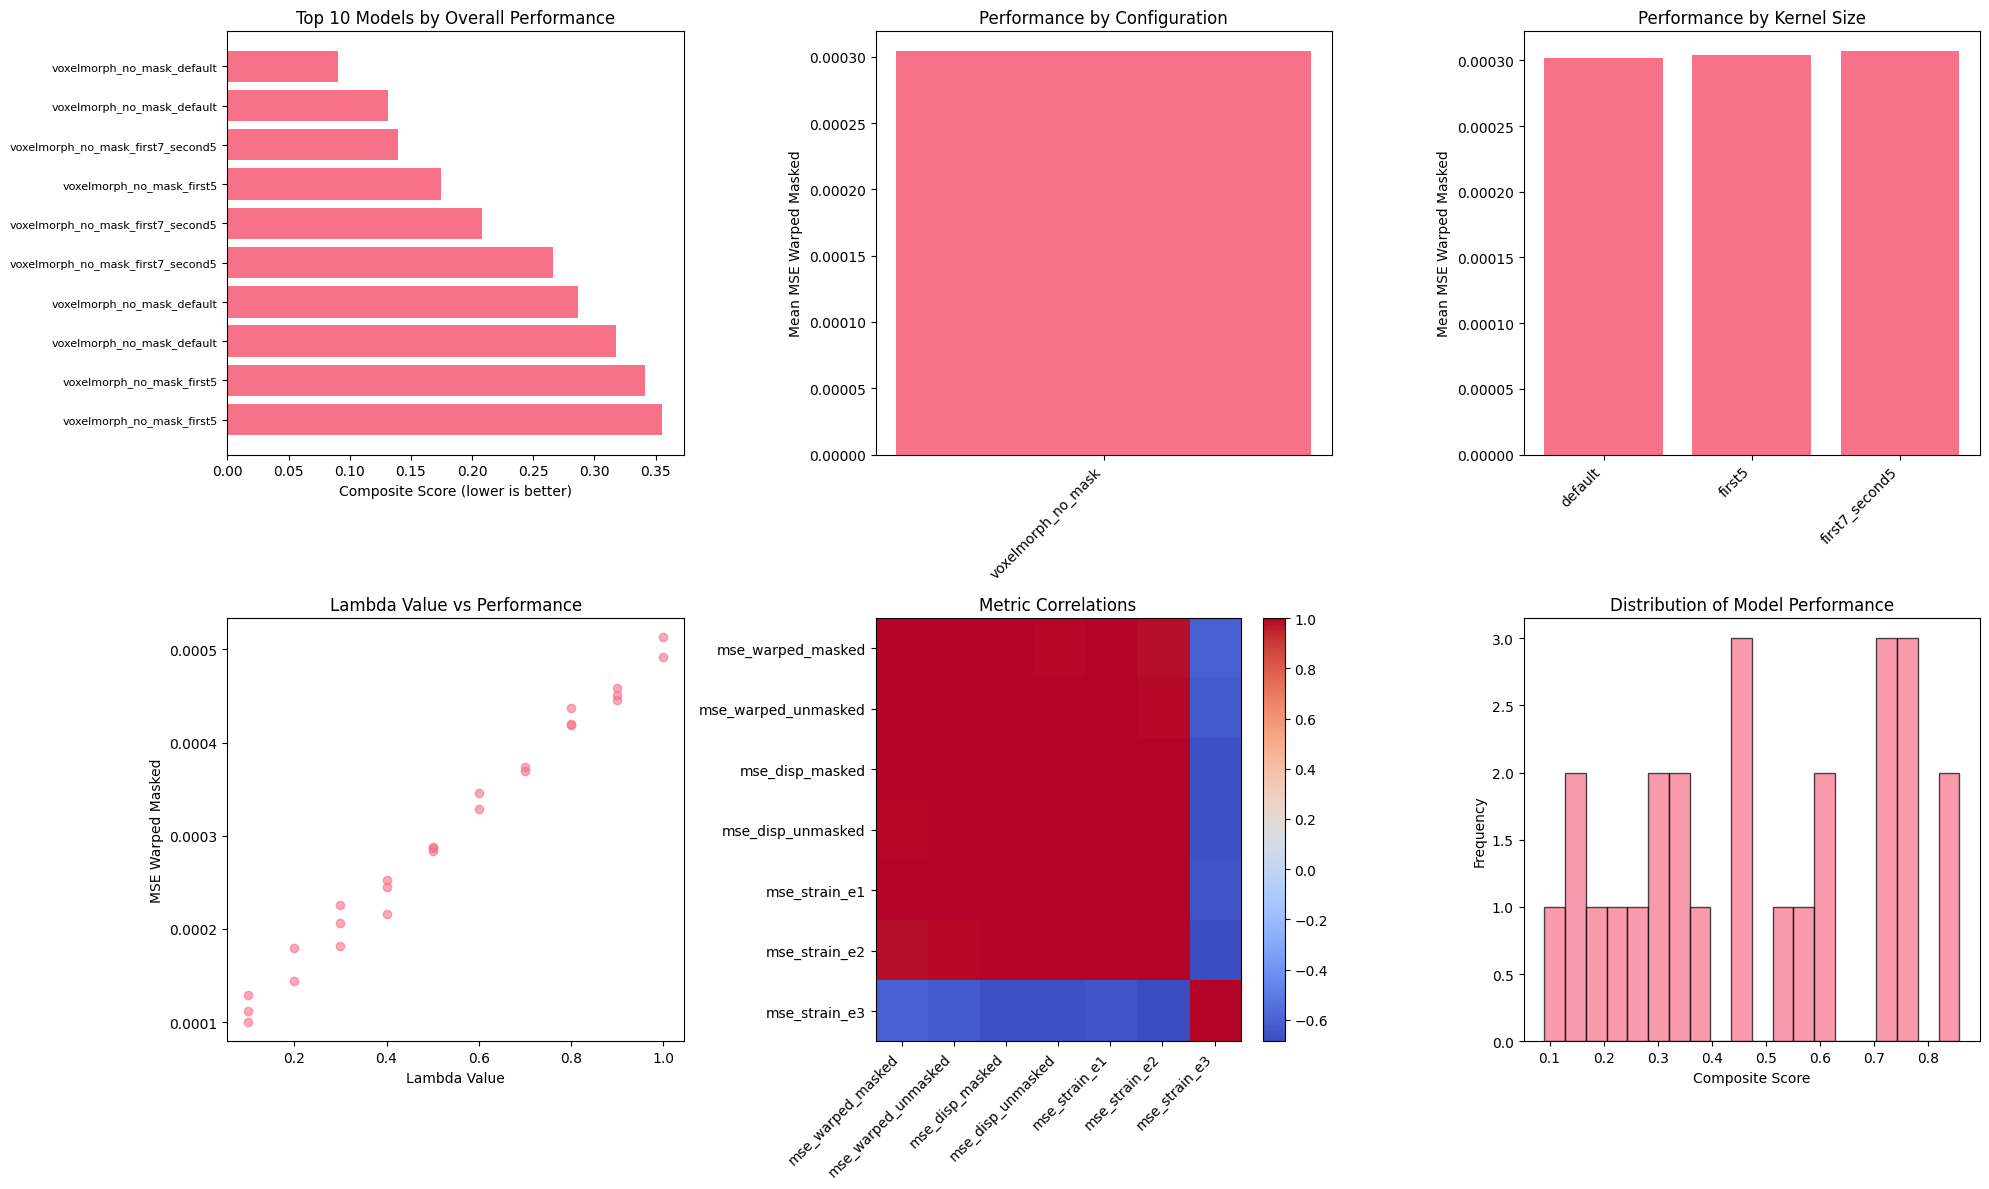

Model comparison results saved to 'model_comparison.csv' and plots to 'model_analysis_plots.png'.

Models comparison completed successfully!

EVALUATION SUMMARY
Total models: 30
Successful: 26
Failed: 4
Success rate: 86.7%
Total time: 0.0 minutes
Average time per model: 0.1 seconds


In [5]:
models_comparison(MODEL_CONFIG, LAMBDAS, KERNEL_KEYS)
